Some code is taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [1]:
#IMPORTANT : set following variable to True iff you run this notebook in Google Colab
#It will allow you to save intermediate results in your Google Drive, in case you are disconnected
COLAB=False

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

SAVEPATH=''
if COLAB:
  from google.colab import drive
  SAVEPATH = '/content/drive/MyDrive/Colab Notebooks/' + SAVEPATH
  drive.mount('/content/drive/')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
#Load the data (CIFAR10)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
#Old version, no sigmoid.
RBVERSION=''
class ResidualBlock(nn.Module):
  def __init__(self, channels, skip=True, adaptive_skip=False, skip_w0=0.5):
    super().__init__()
    self.channels = channels
    self.skip = skip
    self.adaptive_skip = adaptive_skip

    self.conv1 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act2 = nn.LeakyReLU()

    self.skip_w = nn.Parameter(torch.tensor([skip_w0 if skip else 0.0]), requires_grad=adaptive_skip)
    print(f'ResidualBlock initialization: {self.skip_w=}')

  def forward(self, x):
    y = self.conv1(x)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.act2(y)
    return (1 - self.skip_w) * y + self.skip_w * x


In [12]:
RBVERSION='2'
#In this version, the skip_w weight goes through a sigmoid to make it
#bounded between 0 and 1, which yields more interpretable result.
class ResidualBlock(nn.Module):
  def __init__(self, channels, skip=True, adaptive_skip=False, skip_w0=0.0):
    '''
    TODO
    skip_w0 : initialization value for the skip connection weight
    '''
    super().__init__()
    self.channels = channels
    self.skip = skip
    self.adaptive_skip = adaptive_skip

    self.conv1 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.conv2 = nn.Conv2d(channels, channels, 3, padding='same')
    self.act2 = nn.LeakyReLU()

    self.skip_w = nn.Parameter(torch.tensor([skip_w0 if skip else 0.0]), requires_grad=adaptive_skip)
    print(f'ResidualBlock initialization: {self.skip_w=}')

  def forward(self, x):
    y = self.conv1(x)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.act2(y)
    sig_skip_w = torch.sigmoid(self.skip_w) #in (0, 1)
    return (1 - sig_skip_w) * y + sig_skip_w * x

In [13]:
#Old version, significantly less parameters.
MVERSION=''
class Model(nn.Module):
  def __init__(self, skip=True, adaptive_skip=False, skip_w0=0.5):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 12, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(12, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling1 = nn.MaxPool2d(2) #Nx12x16x16
    self.res2 = ResidualBlock(12, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling2 = nn.MaxPool2d(2) #Nx12x8x8
    self.fc = nn.Linear(768, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.pooling2(x)
    x = self.fc(x.view(-1, 768))
    return self.act_final(x)


In [14]:
MVERSION='2'
#More parameters, but still only 2 residual blocks.
class Model(nn.Module):
  def __init__(self, skip=True, adaptive_skip=False, skip_w0=0.0):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 24, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling1 = nn.MaxPool2d(2) #Nx24x16x16
    self.res2 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling2 = nn.MaxPool2d(2) #Nx24x8x8
    self.fc1 = nn.Linear(1536, 128)
    self.fc_act1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.pooling2(x)
    x = self.fc1(x.view(-1, 1536))
    x = self.fc_act1(x)
    x = self.fc2(x)
    return self.act_final(x)


In [15]:
#Now 4 residual blocks. This allows us to see whether the skip weights are in
#increasing / decreasing order based on the depth position of the residual block.
MVERSION='3'
class Model(nn.Module):
  def __init__(self, skip=True, adaptive_skip=False, skip_w0=0.0):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 24, 3, padding='same')
    self.act1 = nn.LeakyReLU()
    self.res1 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling1 = nn.MaxPool2d(2) #Nx6x16x16
    self.res2 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.res3 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)
    self.pooling2 = nn.MaxPool2d(2) #Nx24x8x8
    self.res4 = ResidualBlock(24, skip=skip, adaptive_skip=adaptive_skip, skip_w0=skip_w0)

    self.fc1 = nn.Linear(1536, 128)
    self.fc_act1 = nn.LeakyReLU()
    self.fc2 = nn.Linear(128, 10)
    self.act_final = nn.LogSoftmax()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act1(x)
    x = self.res1(x)
    x = self.pooling1(x)
    x = self.res2(x)
    x = self.res3(x)
    x = self.pooling2(x)
    x = self.res4(x)
    x = self.fc1(x.view(-1, 1536))
    x = self.fc_act1(x)
    x = self.fc2(x)
    return self.act_final(x)

In [16]:
VERSION = RBVERSION + MVERSION
# Used as a prefix for all the saved files to make
# sure it is clear which residual block and which model were used.

In [17]:
def test(net, testloader, return_loss=True):
  correct = 0
  total = 0
  criterion = nn.CrossEntropyLoss()
  total_loss = 0.0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          if return_loss:
            total_loss += criterion(outputs, labels).item()

  if not return_loss:
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    return correct / total
  else:
    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %, loss: {total_loss}')
    return correct / total, total_loss

In [18]:
def train(net, criterion, optimizer, trainloader, epochs, device, loss_history=None, test_each_epoch=False, testloader=None, acc_history=None, testloss_history=None, skip_w_history=None):
  print_freq = 100

  for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if skip_w_history is not None:
          skip_w_history.append((net.res1.skip_w.item(), net.res2.skip_w.item(),
                                 net.res3.skip_w.item(), net.res4.skip_w.item()))

        if (i+1) % print_freq == 0:    # print every 100 mini-batches
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f}')
          running_loss = 0.0
          if skip_w_history:
            print(f'[{epoch + 1}, {i + 1:5d}] skip_w: {skip_w_history[-1]}')

        if loss_history is not None:
          loss_history.append(loss.item())


    if test_each_epoch:
      acc, testloss = test(net, testloader, return_loss=True)
      acc_history.append(acc)
      testloss_history.append(testloss)

print('Finished Training')

Finished Training


In [19]:
####################################
### Test with regular skip connections
####################################

print(f"Using {device=}")
net = Model(skip=True, adaptive_skip=False)
net.to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=1e-2)
optimizer = optim.Adam(net.parameters())
loss_history = []
acc_history = []
testloss_history = []
skip_w_history = None

#Train the model (and test it on the testdata after each epoch)
train(net, criterion, optimizer, trainloader, epochs=2, device=device, loss_history=loss_history,
      test_each_epoch=True, testloader=testloader, acc_history=acc_history, testloss_history=testloss_history,
      skip_w_history=skip_w_history)

#Save the training/testing stats and the model
torch.save(net.state_dict(), SAVEPATH+VERSION+"regskip.pth")
torch.save(loss_history, SAVEPATH+VERSION+"regskip_trainingloss.pth")
torch.save(acc_history, SAVEPATH+VERSION+"regskip_testacc.pth")
torch.save(testloss_history, SAVEPATH+VERSION+"regskip_testloss.pth")

Using device=device(type='cpu')
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])


c:\Users\arthu\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[1,   100] loss: 2.036
[1,   200] loss: 1.679
[1,   300] loss: 1.521
Accuracy of the network on the 10000 test images: 50 %, loss: 109.54737150669098
[2,   100] loss: 1.328
[2,   200] loss: 1.273
[2,   300] loss: 1.224
Accuracy of the network on the 10000 test images: 58 %, loss: 91.38532894849777


In [20]:
####################################
### Test with adaptive skip connections
####################################
print(f"Using {device=}")
net = Model(skip=True, adaptive_skip=True)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
loss_history = []
acc_history = []
testloss_history = []
skip_w_history = []

#Train the model (and test it on the testdata after each epoch)
train(net, criterion, optimizer, trainloader, epochs=2, device=device, loss_history=loss_history,
      test_each_epoch=True, testloader=testloader, acc_history=acc_history, testloss_history=testloss_history,
      skip_w_history=skip_w_history)

#Save the training/testing stats and the model
torch.save(net.state_dict(), SAVEPATH+VERSION+"adaskip.pth")
torch.save(loss_history, SAVEPATH+VERSION+"adaskip_trainingloss.pth")
torch.save(acc_history, SAVEPATH+VERSION+"adaskip_testacc.pth")
torch.save(testloss_history, SAVEPATH+VERSION+"adaskip_testloss.pth")
torch.save(skip_w_history, SAVEPATH+VERSION+"adaskip_skipw.pth")


Using device=device(type='cpu')
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.], requires_grad=True)
[1,   100] loss: 2.009
[1,   100] skip_w: (0.053165994584560394, 0.0822589173913002, 0.058162715286016464, 0.05792776495218277)
[1,   200] loss: 1.652
[1,   200] skip_w: (0.05464108660817146, 0.1334580034017563, 0.07503435760736465, 0.10441910475492477)
[1,   300] loss: 1.505
[1,   300] skip_w: (0.052499089390039444, 0.1618025004863739, 0.08235771209001541, 0.13319998979568481)
Accuracy of the network on the 10000 test images: 50 %, loss: 106.90583658218384
[2,   100] loss: 1.338
[2,   100] skip_w: (0.05232594534754753, 0.20746447145938873, 0.09425021708011627, 0.1807643175

In [21]:
####################################
### Test with no skip connections
####################################

print(f"Using {device=}")
net = Model(skip=False, adaptive_skip=False)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
loss_history = []
acc_history = []
testloss_history = []
skip_w_history = []

#Train the model (and test it on the testdata after each epoch)
train(net, criterion, optimizer, trainloader, epochs=2, device=device, loss_history=loss_history,
      test_each_epoch=True, testloader=testloader, acc_history=acc_history, testloss_history=testloss_history,
      skip_w_history=skip_w_history)

#Save the training/testing stats and the model
torch.save(net.state_dict(), SAVEPATH+VERSION+"noskip.pth")
torch.save(loss_history, SAVEPATH+VERSION+"noskip_trainingloss.pth")
torch.save(acc_history, SAVEPATH+VERSION+"noskip_testacc.pth")
torch.save(testloss_history, SAVEPATH+VERSION+"noskip_testloss.pth")


Using device=device(type='cpu')
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
ResidualBlock initialization: self.skip_w=Parameter containing:
tensor([0.])
[1,   100] loss: 2.025
[1,   100] skip_w: (0.0, 0.0, 0.0, 0.0)
[1,   200] loss: 1.670
[1,   200] skip_w: (0.0, 0.0, 0.0, 0.0)
[1,   300] loss: 1.526
[1,   300] skip_w: (0.0, 0.0, 0.0, 0.0)
Accuracy of the network on the 10000 test images: 48 %, loss: 113.76795029640198
[2,   100] loss: 1.358
[2,   100] skip_w: (0.0, 0.0, 0.0, 0.0)
[2,   200] loss: 1.314
[2,   200] skip_w: (0.0, 0.0, 0.0, 0.0)
[2,   300] loss: 1.245
[2,   300] skip_w: (0.0, 0.0, 0.0, 0.0)
Accuracy of the network on the 10000 test images: 56 %, loss: 97.64063024520874


[(0.0009980839677155018, 0.00026370142586529255, 0.0007857215823605657, 0.0011463566916063428, 0.0012360612163320184, 0.0013179539237171412, 0.0011012875474989414, 0.0008764466037973762, 0.0010880832560360432, 0.0015913048991933465, 0.002251001540571451, 0.0030077805276960135, 0.0038424688391387463, 0.004737670533359051, 0.005682110786437988, 0.006652149371802807, 0.007633469998836517, 0.008652160875499249, 0.009704811498522758, 0.010731931775808334, 0.011780016124248505, 0.012750032357871532, 0.013753125444054604, 0.014575117267668247, 0.015491429716348648, 0.01628410816192627, 0.016940679401159286, 0.017565982416272163, 0.018348323181271553, 0.01905965618789196, 0.019585663452744484, 0.01978272758424282, 0.020234987139701843, 0.020796513184905052, 0.0212383009493351, 0.021768009290099144, 0.02239750139415264, 0.023058153688907623, 0.02378695085644722, 0.024593131616711617, 0.025352902710437775, 0.026192640885710716, 0.0270150788128376, 0.027827225625514984, 0.02862146683037281, 0.029

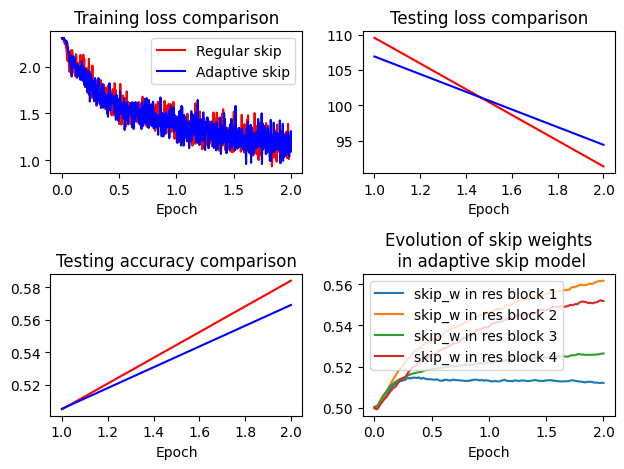

In [23]:
fig, axs = plt.subplots(2, 2)

sample_freq = 1 #only plot every sample_freq-th loss to avoid overloadig the plot...
regskip_trainingloss = torch.load(SAVEPATH+VERSION+"regskip_trainingloss.pth")[::sample_freq]
adaskip_trainingloss = torch.load(SAVEPATH+VERSION+"adaskip_trainingloss.pth")[::sample_freq]

regskip_testloss = torch.load(SAVEPATH+VERSION+"regskip_testloss.pth")
adaskip_testloss = torch.load(SAVEPATH+VERSION+"adaskip_testloss.pth")

regskip_acc = torch.load(SAVEPATH+VERSION+"regskip_testacc.pth")
adaskip_acc = torch.load(SAVEPATH+VERSION+"adaskip_testacc.pth")

skipw = list(zip(*torch.load(SAVEPATH+VERSION+"adaskip_skipw.pth")[::sample_freq]))
print(skipw)

x_axis = torch.linspace(0, 2, len(adaskip_trainingloss))

axs[0][0].set_title("Training loss comparison")
axs[0][0].plot(x_axis, regskip_trainingloss, color="r", label="Regular skip")
axs[0][0].plot(x_axis, adaskip_trainingloss, color="b", label="Adaptive skip")
axs[0][0].legend()

axs[0][1].set_title("Testing loss comparison")
axs[0][1].plot(range(1, 3), regskip_testloss, color="r")
axs[0][1].plot(range(1, 3), adaskip_testloss, color="b")

axs[1][0].set_title("Testing accuracy comparison")
axs[1][0].plot(range(1, 3), regskip_acc, color="r")
axs[1][0].plot(range(1, 3), adaskip_acc, color="b")

axs[1][1].set_title("Evolution of skip weights\n in adaptive skip model")
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[0])), label="skip_w in res block 1")
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[1])), label="skip_w in res block 2")
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[2])), label="skip_w in res block 3")
axs[1][1].plot(x_axis, torch.sigmoid(torch.tensor(skipw[3])), label="skip_w in res block 4")
axs[1][1].legend()

for ax in axs.flatten():
  ax.set_xlabel("Epoch")
  #ax.label_outer()

fig.tight_layout()
plt.show()



[(0.0009980839677155018, 0.01628410816192627, 0.032867249101400375, 0.048478804528713226, 0.053149446845054626, 0.05767395347356796, 0.058705948293209076, 0.05634959787130356, 0.05465470254421234, 0.052528176456689835, 0.05311506614089012, 0.053929246962070465, 0.052300840616226196, 0.05209691449999809, 0.05418198183178902, 0.05297910422086716, 0.05076397582888603, 0.050863247364759445, 0.05239976942539215, 0.052414096891880035, 0.05274563282728195, 0.0517381988465786, 0.053569063544273376, 0.051642484962940216, 0.05346314609050751, 0.0515434555709362, 0.05126555636525154, 0.053374603390693665, 0.05056023225188255, 0.050057459622621536, 0.04854113608598709, 0.04854468256235123), (-0.0009983215713873506, 0.015802625566720963, 0.040978629142045975, 0.0655040517449379, 0.08333539962768555, 0.10222835838794708, 0.11469224095344543, 0.12604930996894836, 0.13377921283245087, 0.1397428810596466, 0.1503027379512787, 0.15625624358654022, 0.16176407039165497, 0.17032097280025482, 0.1785226017236

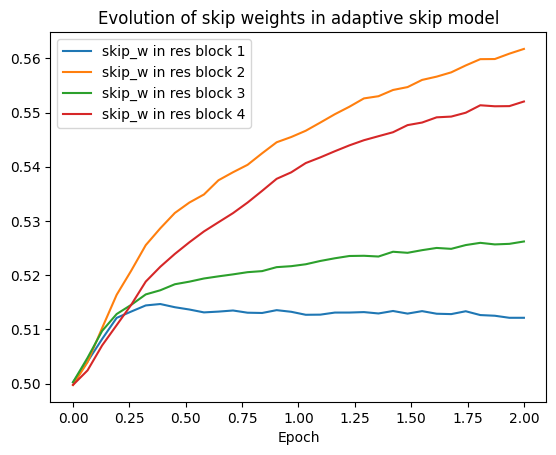

In [24]:
sample_freq=25
skipw = list(zip(*torch.load(SAVEPATH+VERSION+"adaskip_skipw.pth")[::sample_freq]))
print(skipw)

x_axis = torch.linspace(0, 2, len(skipw[0]))

plt.title("Evolution of skip weights in adaptive skip model")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[0])), label="skip_w in res block 1")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[1])), label="skip_w in res block 2")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[2])), label="skip_w in res block 3")
plt.plot(x_axis, torch.sigmoid(torch.tensor(skipw[3])), label="skip_w in res block 4")
plt.xlabel("Epoch")
plt.legend()

plt.show()